# Analyze modeling results


This is the third notebook in a series of Jupyter Notebooks linked to the project titled "__Developing Mechanism-Based Models for Complex Toxicology Study Endpoints Using Standardized Electronic Submission Data__".  The first two notebooks that creates the training set and the models should be run before this one.  

This script mostly just reads and computes statistics on the various models created in the second notebook `2_create_pls_models`.  It currently only evaluates the cross validation predictions.  

The bulk of the code is dedicated to parsing the `params.csv` file and grouping by the `mdl_idx` parameter, which should just be an index of 0-(_n_-1) and each index should be associated with 10 different models each with a different number of principal components. For every mdl_idx, the groupby finds which model (i.e., which number of principal components for each subset) is the best as measured by balanced accuracy.  Animals with model predictions (disease positive animals) are merged.  The result is a dictionary with liver phenotypes as keys and that final statistics as values.  

In [268]:
import os
import numpy as np, pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [269]:
def get_class_stats(model, X: np.array, y: np.array, return_preds=False) -> dict:
    
    from sklearn import utils
    from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score
    from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.metrics import make_scorer

    """
    If model == None, assume X == y_true and y == y_pred, else should be a trained model
    returns a dictionary of
    """
    if not model:
        predicted_classes = y
        predicted_probas = y
        y = X
    else:
        if 'predict_classes' in dir(model):
            predicted_classes = model.predict_classes(X, verbose=0)[:, 0]
            predicted_probas = model.predict_proba(X, verbose=0)[:, 0]
        else:
            predicted_classes = model.predict(X)
            predicted_probas = model.predict_proba(X)[:, 1]

    acc = accuracy_score(y, predicted_classes)
    f1_sc = f1_score(y, predicted_classes)

    cohen_kappa = cohen_kappa_score(y, predicted_classes)
    matthews_corr = matthews_corrcoef(y, predicted_classes)
    precision = precision_score(y, predicted_classes)
    recall = recall_score(y, predicted_classes)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y, predicted_classes, labels=[0,1]).ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)

    if return_preds:
        stats = {'ACC': acc, 'F1-Score': f1_sc, 'AUC': roc_auc, 'Cohen\'s Kappa': cohen_kappa,
         'MCC': matthews_corr, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'NPV': npv}

        return stats, predicted_classes, predicted_probas

    return {'ACC': acc, 'F1-Score': f1_sc, 'Cohen\'s Kappa': cohen_kappa,
            'MCC': matthews_corr, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'NPV': npv}


In [270]:
# Define species to make a training set
# and make a seperate folder to store
# all the resulting data

species = 'RAT'

if not os.path.exists('data'):
    os.mkdir('data')
    
species_data = os.path.join('data', species)
if not os.path.exists(species_data):
    os.mkdir(species_data)
    
training_data_file = os.path.join(species_data, f'{species}_training_data.csv')
prediction_folder = os.path.join(species_data, 'predictions')
model_folder = os.path.join(species_data, 'models')

In [271]:
def get_statistics_dictionary(train_or_cv):

    diseases = ['NECROSIS', 'CHOLESTASIS', 'STEATOSIS']

    final_predictions = {}
    final_stats = {}
    dfs = []

    animals = pd.read_csv(training_data_file, index_col=0)

    for i, d_name in enumerate(diseases):
        disease = animals[d_name]
        disease.index = animals.USUBJID

        prediction_disease_folder = os.path.join(prediction_folder, d_name)
        model_disease_folder = os.path.join(model_folder, d_name)

        cv_predictions = pd.read_csv(os.path.join(prediction_disease_folder, '{}_predictions.csv'.format(train_or_cv)), index_col=0)
        params = pd.read_csv(os.path.join(model_disease_folder, 'params.csv'), index_col=0)


        prediction_data = params.merge(cv_predictions)
        prediction_data.loc[prediction_data.PREDICTION < 0.5, 'PREDICTION_CLASS'] = 0
        prediction_data.loc[prediction_data.PREDICTION >= 0.5, 'PREDICTION_CLASS'] = 1


        stats = []
        for gp, gp_data in prediction_data.groupby(['MDL_ID', 'N_COMPONENTS']):
            stats_dic = get_class_stats(None, disease.loc[gp_data.USUBJID], gp_data.PREDICTION_CLASS)
            stats_dic['MDL_ID'] = gp[0]
            stats_dic['N_COMPONENTS'] = gp[1]
            stats_dic['ID'] = gp_data.ID.iloc[0]
            stats.append(stats_dic)

        stats_df = pd.DataFrame(stats)

        stats_df['BAL_ACC'] = (stats_df['Recall'] + stats_df['Specificity']) / 2


        best_models = stats_df.groupby('MDL_ID').apply(lambda g: g[g['BAL_ACC'] == g['BAL_ACC'].max()].iloc[0])
        best_model_predictions = prediction_data[prediction_data.ID.isin(best_models.ID)]

        best_model_predictions.loc[:, 'PREDICTION_MEAN'] = best_model_predictions.groupby('USUBJID')['PREDICTION'].transform('mean')
        best_model_predictions.loc[:, 'PREDICTION_STD'] = best_model_predictions.groupby('USUBJID')['PREDICTION'].transform('std')

        best_model_predictions.loc[best_model_predictions.PREDICTION_MEAN < 0.5, 'PREDICTION_MEAN_CLASS'] = 0
        best_model_predictions.loc[best_model_predictions.PREDICTION_MEAN >= 0.5, 'PREDICTION_MEAN_CLASS'] = 1

        final_data = best_model_predictions.drop_duplicates(['USUBJID', 'PREDICTION_MEAN_CLASS'])

        final_data = final_data.merge(animals[['USUBJID', d_name]])


        final_predictions[d_name] = final_data
        
        
        final_stats[d_name] = get_class_stats(None, final_data[d_name], final_data.PREDICTION_MEAN_CLASS)
        final_stats[d_name]['Bal Acc'] = (final_stats[d_name]['Recall'] + final_stats[d_name]['Specificity']) / 2
    return final_stats


def get_prediction_dictionary(train_or_cv):

    diseases = ['NECROSIS', 'CHOLESTASIS', 'STEATOSIS']

    final_predictions = {}

    animals = pd.read_csv(training_data_file, index_col=0)

    for i, d_name in enumerate(diseases):
        disease = animals[d_name]
        disease.index = animals.USUBJID

        prediction_disease_folder = os.path.join(prediction_folder, d_name)
        model_disease_folder = os.path.join(model_folder, d_name)

        cv_predictions = pd.read_csv(os.path.join(prediction_disease_folder, '{}_predictions.csv'.format(train_or_cv)), index_col=0)
        params = pd.read_csv(os.path.join(model_disease_folder, 'params.csv'), index_col=0)


        prediction_data = params.merge(cv_predictions)
        prediction_data.loc[prediction_data.PREDICTION < 0.5, 'PREDICTION_CLASS'] = 0
        prediction_data.loc[prediction_data.PREDICTION >= 0.5, 'PREDICTION_CLASS'] = 1


        stats = []
        for gp, gp_data in prediction_data.groupby(['MDL_ID', 'N_COMPONENTS']):
            stats_dic = get_class_stats(None, disease.loc[gp_data.USUBJID], gp_data.PREDICTION_CLASS)
            stats_dic['MDL_ID'] = gp[0]
            stats_dic['N_COMPONENTS'] = gp[1]
            stats_dic['ID'] = gp_data.ID.iloc[0]
            stats.append(stats_dic)

        stats_df = pd.DataFrame(stats)

        stats_df['BAL_ACC'] = (stats_df['Recall'] + stats_df['Specificity']) / 2


        best_models = stats_df.groupby('MDL_ID').apply(lambda g: g[g['BAL_ACC'] == g['BAL_ACC'].max()].iloc[0])
        best_model_predictions = prediction_data[prediction_data.ID.isin(best_models.ID)]

        best_model_predictions.loc[:, 'PREDICTION_MEAN'] = best_model_predictions.groupby('USUBJID')['PREDICTION'].transform('mean')
        best_model_predictions.loc[:, 'PREDICTION_STD'] = best_model_predictions.groupby('USUBJID')['PREDICTION'].transform('std')

        best_model_predictions.loc[best_model_predictions.PREDICTION_MEAN < 0.5, 'PREDICTION_MEAN_CLASS'] = 0
        best_model_predictions.loc[best_model_predictions.PREDICTION_MEAN >= 0.5, 'PREDICTION_MEAN_CLASS'] = 1

        final_data = best_model_predictions.drop_duplicates(['USUBJID', 'PREDICTION_MEAN_CLASS'])

        final_data = final_data.merge(animals[['USUBJID', d_name]])


        final_predictions[d_name] = final_data
        final_stats[d_name] = get_class_stats(None, final_data[d_name], final_data.PREDICTION_MEAN_CLASS)
    return final_predictions

In [272]:
train_stats = get_statistics_dictionary('train')
cv_stats = get_statistics_dictionary('cv')

In [273]:
train_stats['NECROSIS']

{'ACC': 0.7727509401214926,
 'F1-Score': 0.15888650963597428,
 "Cohen's Kappa": 0.09890367100824049,
 'MCC': 0.15300602305378103,
 'Precision': 0.09279639819909954,
 'Recall': 0.5520833333333334,
 'Specificity': 0.7816769999398062,
 'NPV': 0.9773462783171522,
 'Bal Acc': 0.6668801666365698}

In [274]:
cv_stats

{'NECROSIS': {'ACC': 0.7539485102690194,
  'F1-Score': 0.1364467005076142,
  "Cohen's Kappa": 0.07428907402633245,
  'MCC': 0.11858299920713415,
  'Precision': 0.0790030566658829,
  'Recall': 0.5,
  'Specificity': 0.7642207909468488,
  'NPV': 0.9742173112338858,
  'Bal Acc': 0.6321103954734244},
 'CHOLESTASIS': {'ACC': 0.7175585768006942,
  'F1-Score': 0.11074681238615666,
  "Cohen's Kappa": 0.0673416290362926,
  'MCC': 0.14281042383544096,
  'Precision': 0.06016227983376212,
  'Recall': 0.6956521739130435,
  'Specificity': 0.7181267806267806,
  'NPV': 0.9891268803139307,
  'Bal Acc': 0.706889477269912},
 'STEATOSIS': {'ACC': 0.6077523864622505,
  'F1-Score': 0.23768832921070385,
  "Cohen's Kappa": 0.08461747470390557,
  'MCC': 0.12023561981290676,
  'Precision': 0.14933597061316756,
  'Recall': 0.5820484581497798,
  'Specificity': 0.6107699269506756,
  'NPV': 0.9256392671695896,
  'Bal Acc': 0.5964091925502277}}

## Plotting a bar graph using seabron

In [278]:
cv_stats_df = pd.DataFrame.from_dict(cv_stats)
train_stats_df = pd.DataFrame.from_dict(train_stats)

cv_stats_df.T['Bal Acc'] = (cv_stats_df.T['Recall'] + cv_stats_df.T['Specificity']) / 2
train_stats_df.T['Bal Acc'] = (train_stats_df.T['Recall'] + train_stats_df.T['Specificity']) / 2

cv_stats_df['SET'] = ['10 Fold CV']*len(cv_stats_df)
train_stats_df['SET'] = ['Training Set']*len(train_stats_df)

df = pd.concat([cv_stats_df, train_stats_df])

df = df.loc[~df.index.isin(['ACC', 'F1-Score', "Cohen's Kappa", "MCC", "NPV"])]
df = df.reset_index().melt(id_vars=['index', 'SET']).rename({'index': 'Metric', 'SET': 'Set', 'variable':'Disease'}, axis=1)

df.head()

,Metric,Set,Disease,value
0,Precision,10 Fold CV,NECROSIS,0.079003
1,Recall,10 Fold CV,NECROSIS,0.500000
2,Specificity,10 Fold CV,NECROSIS,0.764221
3,Bal Acc,10 Fold CV,NECROSIS,0.632110
4,Precision,Training Set,NECROSIS,0.092796


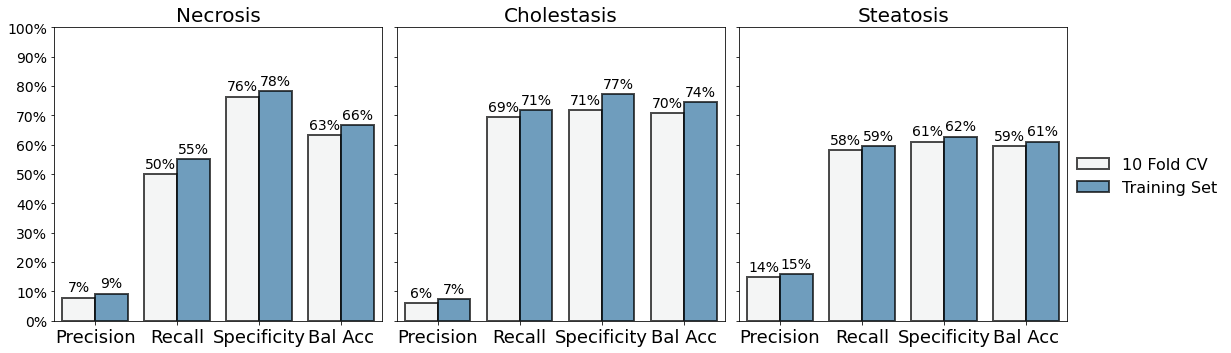

In [279]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['patch.edgecolor'] = 'black'
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(df, col="Disease",
# subplot_kws=dict(),
                  sharex=False, sharey=True, despine=False, ylim=(0, 1), size=5)

# Draw a scatterplot onto each axes in the grid
g.map(sns.barplot, "Metric", "value", "Set")

dis = ['Necrosis', 'Cholestasis', 'Steatosis']
i=0
for ax in g.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(['{:.0f}%'.format(100*t) for t in ax.get_yticks()], fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(dis[i], fontsize=20)
    i = i + 1
    
for ax in g.axes.flatten():
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
        patch.set_alpha(0.7)
        ax.text(patch.get_xy()[0] + (patch.get_width()/2), patch.get_height()+0.01, '{}%'.format(int(100*patch.get_height())), va='bottom', ha='center', fontsize=14)

g.add_legend(fontsize=16)

plt.savefig(f'data/{species}/figures/modeling_results.png', transparent=True)


## Plot Histogram of Probability 

Only do this for the 10 fold cross validtion.  

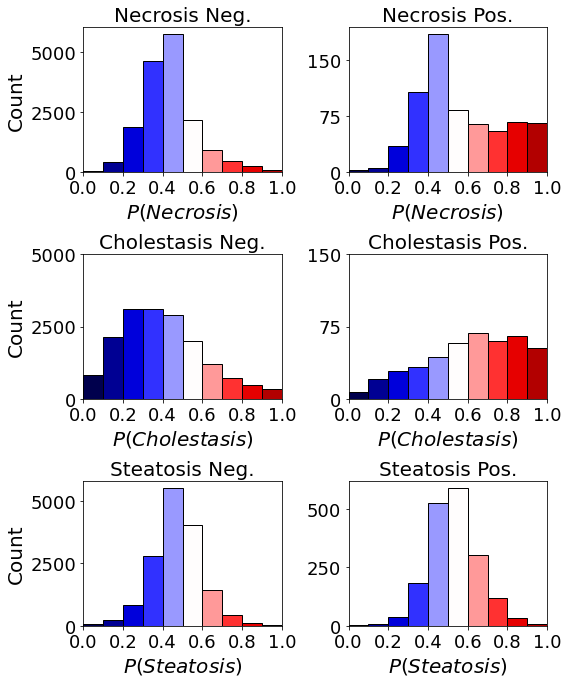

In [285]:
fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=plt.figaspect(3/2.5)*2, sharex=False)

# train_predictions = get_prediction_dictionary('train')
cv_predictions = get_prediction_dictionary('cv')

diseases = ['NECROSIS', 'CHOLESTASIS', 'STEATOSIS']

for i, d_name in enumerate(diseases):

    plot_data = cv_predictions[d_name]

    bin_defs = np.arange(0, 1.1, 0.1)

    N, bins, patches = axarr[i, 0].hist(plot_data.PREDICTION_MEAN[plot_data[d_name] == 0], zorder=2, bins=bin_defs)

    for b, thispatch in zip(bins, patches):
        color = plt.cm.seismic(b)
        thispatch.set_facecolor(color)
        thispatch.set_edgecolor('black')

    N, bins, patches = axarr[i, 1].hist(plot_data.PREDICTION_MEAN[plot_data[d_name] == 1], zorder=2, bins=bin_defs)
    for b, thispatch in zip(bins, patches):
        color = plt.cm.seismic(b)
        thispatch.set_facecolor(color)
        thispatch.set_edgecolor('black')
    stats = get_class_stats(None, plot_data[d_name], plot_data.PREDICTION_MEAN_CLASS)

    n = final_data.shape[0]
    sens, spec, acc, ppv = stats['Recall'], stats['Specificity'], (stats['Recall']+stats['Specificity'])/2, stats['Precision']
    s = 'Sensitivity: {:.2f}%, Specificity: {:.2f}%, BalAcc: {:.2f}%, PPV: {:.2f}%, N: {}'.format(sens*100, spec*100, acc*100, ppv*100, n)

    axarr[i, 0].set_ylabel('Count', fontsize=20)

    axarr[i, 0].set_title('{} Neg.'.format(d_name.title()), fontsize=20)
    axarr[i, 1].set_title('{} Pos.'.format(d_name.title()), fontsize=20)

    axarr[i, 0].set_xlabel(f'$P({d_name.title()})$', fontsize=20)
    axarr[i, 1].set_xlabel(f'$P({d_name.title()})$', fontsize=20)


    for idx in [0, 1]:
        axarr[i, idx].set_xlim(0, 1)
        axarr[i, idx].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
    axarr[i, 0].set_yticks([0, 2500, 5000])
    
    if d_name == 'STEATOSIS':
        axarr[i, 1].set_yticks([0, 250, 500])
    else:
        axarr[i, 1].set_yticks([0, 75, 150])
    
    axarr[i, 0].set_xticklabels(axarr[i, 0].get_xticks(), fontsize=18)
    axarr[i, 1].set_xticklabels(axarr[i, 1].get_xticks(), fontsize=18)
    
    axarr[i, 0].set_yticklabels(axarr[i, 0].get_yticks(), fontsize=18)
    axarr[i, 1].set_yticklabels(axarr[i, 1].get_yticks(), fontsize=18)

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.tight_layout()
plt.savefig(f'data/{species}/figures/average_model_preds.png', transparent=True)